<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/TEST_Camembert_LM%26TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 8.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 


In [2]:
!pip install -Uq transformers
from fastai.text.all import *

     |████████████████████████████████| 2.3MB 8.1MB/s 
     |████████████████████████████████| 3.3MB 52.0MB/s 
     |████████████████████████████████| 901kB 49.0MB/s 


In [88]:
!pip install -Uq nbdev

In [89]:
from inspect import signature

In [4]:
# # better display of review text in dataframes
# pd.set_option('display.max_colwidth', None) 

# CamentBERT

In [5]:
!pip install sentencepiece

from transformers import CamembertTokenizer, CamembertForCausalLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True)
model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True, add_cross_attention=True)

#transformers.RobertaForCausalLM.from_pretrained(pretrained_model_name_or_path='roberta-base', add_cross_attention=True, is_decoder=True, bos_token_id=<bos-id>, eos_token_id=<eos-id>)?

     |████████████████████████████████| 1.2MB 7.5MB/s 


Some weights of CamembertForCausalLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta.encoder.layer.1.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.5.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.output.dense.bias', 'roberta.encoder.layer.7.crossattention.self.value.weight', 'roberta.encoder.layer.11.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.dense.bias', 'roberta.encoder.layer.8.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.self.value.weight', 'roberta.encoder.layer.5.crossattention.output.dense.bias', 'roberta.encoder.layer.2.crossattention.self.value.bias', 'roberta.encoder.layer.3.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.10.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.5.cross

NOTE: Language Modeling
- **Causal language modeling**: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.
- **Masked language modeling**: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

In [6]:
model.eval()

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Testing the tokenizer

In [7]:
tokenizer.vocab_size

32005

In [8]:
ids = tokenizer.encode('Ce texte est affligeant, et')
ids

[5, 148, 930, 30, 5639, 1187, 17059, 7, 14, 6]

In [9]:
# decoding
tokenizer.decode(ids)

'<s> Ce texte est affligeant, et</s>'

# Getting the data

In [10]:
#creating a directory allocine
path = Path('/content/allocine/')
path.mkdir(parents=True, exist_ok=True)

In [11]:
#creating a directory allocine
path = Path('/content/allocine/models')
path.mkdir(parents=True, exist_ok=True)

In [12]:
path = Path('/content/allocine/'); path

Path('/content/allocine')

In [13]:
# downloading the AlloCine dataset
!wget -q https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/raw/master/allocine_dataset/data.tar.bz2
!tar -xf /content/data.tar.bz2 -C '/content/allocine'

In [14]:
train_df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=10000)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


NOTE: polarity: `0` negative review; `1` positive review

In [15]:
val_df = pd.read_json(path/'data/val.jsonl', lines=True, nrows=1000)
val_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [16]:
train_df.to_csv(path/'data/train.csv', encoding = 'utf-8', header = False, index = False)

In [17]:
val_df.to_csv(path/'data/val.csv', encoding = 'utf-8', header = False, index = False)

In [18]:
# training dataset
df_train = pd.read_csv(path/'data/train.csv', encoding = 'utf-8', header=None)
df_train.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0
1,http://www.allocine.fr/film/fichefilm-172430/critiques/spectateurs,"Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la sauce années 2000 : les dandys-punk de Kubrick ont laissé place à des papys lubriques déguisés en sacs-poubelles forniquant les troncs d'arbres, le dispositif esthétique se résume à du filmage-réalité enfilant des scènes de destruction, de soumission, de pornographie ou encore de maltraitance ( youtube, youtube et re-youtube...) et la bande-son se limite à des ricanements malades, des rengaine...",0


In [19]:
# validation dataset
df_valid = pd.read_csv(path/'data/val.csv', encoding = 'utf-8', header=None)
df_valid.head(2)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0
1,http://www.allocine.fr/film/fichefilm-272/critiques/spectateurs,"The Wall a été réalisé par Alan Parker (Fame, Midnight Express, Evita) et Roger Waters (bassiste de Pink Floyd). Le film ne contient quasiment aucun dialogue, il s'agit en fait du double album conceptuel The Wall en images. Pink est une rock star déchue qui utilise tous les paradis artificiels possibles pour fuir le réel, mais cela ne fait que l'enfoncer encore plus dans son état sombre. Ce film est tout autant fascinant que dérangeant : on regarde cet homme sombrer dans la paranoïa, sans pouvoir rien faire, comme les spectateurs pervers d'une mise à mort, fascinés par cette chose incontrô...",1


In [20]:
print(train_df['polarity'].unique(), val_df['polarity'].unique())

[0 1] [0 1]


In [21]:
all_texts = np.concatenate([df_train[1].values, df_valid[1].values])

In [22]:
print(len(train_df), len(val_df), len(all_texts))

10000 1000 11000


### Testing the tokenizer on movie review

In [23]:
some_review = train_df.review[0]; some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [24]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [25]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [26]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

In [27]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [28]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [29]:
# tls.train[0],tls.valid[0]

In [30]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([332]), torch.Size([93]))

In [31]:
show_at(tls.train, 0)

Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mouvements(!!)ou laiss

In [32]:
show_at(tls.valid, 0)

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.


## Dataloader

In [33]:
#bs,sl = 4,256 # not working
bs,sl = 4, 256
dls_lm = tls.dataloaders(bs=bs, seq_len=sl)

In [34]:
dls_lm.tfms

Pipeline: TransformersTokenizer

In [35]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"On atteint ici les limites du supportable en terme de nullité. Une difficile fin de carrière pour Shelley Winters qui tient malgré tout son rôle avec professionnalisme et une tache sur le cv pour les autres acteurs. Des femmes nues, enchainées et suppliciées ne suffisent pas à faire un bon film... Et rajouter des Harley et des Cadillac ne suffit pas à garder éveillé le spectateur qui se perd dans cette histoire sans queue ni tête, où le rêve et la réalité se mélangent sans cesse, pour aboutir au néant total d'une histoire de l'épaisseur d'un cheveu d'Arielle Dombasle, qu'elle a fort beaux d'ailleurs. Les acteurs font de leur mieux pour sauver le film du désastre. Seul petit plaisir: de beaux plans de Marrakech. Il est plutôt marrant ce petit film, c'est un hommage aux films de SF des années 50. Quelques scènes sont bien rigolotes (la bénédiction avant le","atteint ici les limites du supportable en terme de nullité. Une difficile fin de carrière pour Shelley Winters qui tient malgré tout son rôle avec professionnalisme et une tache sur le cv pour les autres acteurs. Des femmes nues, enchainées et suppliciées ne suffisent pas à faire un bon film... Et rajouter des Harley et des Cadillac ne suffit pas à garder éveillé le spectateur qui se perd dans cette histoire sans queue ni tête, où le rêve et la réalité se mélangent sans cesse, pour aboutir au néant total d'une histoire de l'épaisseur d'un cheveu d'Arielle Dombasle, qu'elle a fort beaux d'ailleurs. Les acteurs font de leur mieux pour sauver le film du désastre. Seul petit plaisir: de beaux plans de Marrakech. Il est plutôt marrant ce petit film, c'est un hommage aux films de SF des années 50. Quelques scènes sont bien rigolotes (la bénédiction avant le repas"
1,"pure. GENIAL Etant fan de Tomi Ungerer, je me suis précipitée sur cette adaptation du fameux conte qui a bercé notre enfance. Je n'ai pas été déçue! c'est un film d'une beauté incroyable. A voir absolument. La mayonnaise ne prend pas, Vincent Lindon ne peut pas toujours avoir raison dans ses choix! Un Capra de trop, vraiment décevant de la part d'un aussi grand cinéaste. C'est à croire que Sinatra l'a fortement influencé dans le choix de ses séquences. Ce film est inintéressant au possible tant il tire sur les cordes sentimentales de façon laborieuse. On a tout compris en 5 minutes et il n'y a plus rien à voir, juste un duo chanté à écouter entre le père et le fils à mi-parcourt. Les acteurs ne sont nullement en cause, seule Carolyne Jones est sous utilisée et en plus on ne sait même pas ce qu'elle devient ce qui",". GENIAL Etant fan de Tomi Ungerer, je me suis précipitée sur cette adaptation du fameux conte qui a bercé notre enfance. Je n'ai pas été déçue! c'est un film d'une beauté incroyable. A voir absolument. La mayonnaise ne prend pas, Vincent Lindon ne peut pas toujours avoir raison dans ses choix! Un Capra de trop, vraiment décevant de la part d'un aussi grand cinéaste. C'est à croire que Sinatra l'a fortement influencé dans le choix de ses séquences. Ce film est inintéressant au possible tant il tire sur les cordes sentimentales de façon laborieuse. On a tout compris en 5 minutes et il n'y a plus rien à voir, juste un duo chanté à écouter entre le père et le fils à mi-parcourt. Les acteurs ne sont nullement en cause, seule Carolyne Jones est sous utilisée et en plus on ne sait même pas ce qu'elle devient ce qui"


## Tokenizing the Allocine Dataset

In [36]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [37]:
len(tokenized)

11000

In [38]:
tokenizer.vocab_size

32005

In [39]:
# adding tokens to the vocab
tokenizer.add_tokens('tokenized')
# resizing the model
model.resize_token_embeddings(len(tokenizer))

Embedding(32006, 768)

In [40]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

## Learner

In [41]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [42]:
# del learn

In [43]:
learn = Learner(dls_lm, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [44]:
learn.model

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32006, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [45]:
learn.validate()

(#2) [14.145498275756836,1390951.0]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

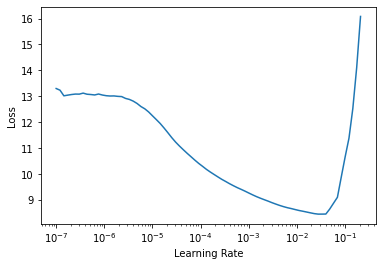

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.150712,3.964910,52.715538,03:53


## Saving the trained model

In [48]:
# saving the newly trained model
learn.save('1epoch')

Path('models/1epoch.pth')

## Saving the model's vocabulary

In [49]:
# saving the vocabulary
vocab= tokenizer.save_vocabulary('/content/allocine/data/')

NOTE: the file name is `sentencepiece.bpe.model`

In [50]:
# other way to save the vocabulary by making a list
vocab_lm = list(tokenizer.get_vocab()) #dictionary

In [51]:
vocab_lm[:10]

['<s>NOTUSED',
 '<pad>',
 '</s>NOTUSED',
 '<unk>',
 '<s>',
 '</s>',
 ',',
 '▁de',
 '.',
 's']

In [52]:
type(vocab_lm)

list

In [53]:
len(vocab_lm)

32005

In [54]:
# vocab size assertion
assert(len(vocab_lm) == tokenizer.vocab_size) # it returns True!

## Inference

In [55]:
df_valid.head(1)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [56]:
#prompt = "ce film est un navet, il met en"
prompt = "c'est une histoire abracadabrantesque"

In [57]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 13])

In [58]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

In [59]:
tokenizer.decode(preds[0].cpu().numpy())

"<s> c'est une histoire abracadabrantesque</s> on se demande ce que l'on peut faire dans ce genre de film. Le scénario est bien ficelé et les acteurs sont"

NOTE: The model 'RobertaForCausalLM' is not supported for text-generation. Supported models are ['XLNetLMHeadModel', 'TransfoXLLMHeadModel', 'ReformerModelWithLMHead', 'GPT2LMHeadModel', 'GPTNeoForCausalLM', 'OpenAIGPTLMHeadModel', 'CTRLLMHeadModel', 'TFXLNetLMHeadModel', 'TFTransfoXLLMHeadModel', 'TFGPT2LMHeadModel', 'TFOpenAIGPTLMHeadModel', 'TFCTRLLMHeadModel']

# Text Classification

In [60]:
path

Path('/content/allocine')

In [61]:
df = pd.read_json(path/'data/train.jsonl', lines=True, nrows=30000)
df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [62]:
# splitting a df by rows
df_train = df.iloc[10001:-1]; len(df_train)

19998

In [63]:
df_train.to_csv(path/'data/train1.csv', encoding = 'utf-8', header = True, index = False)

In [64]:
df_train.head(1)

,film-url,review,polarity
10001,http://www.allocine.fr/film/fichefilm-50911/critiques/spectateurs,"Quel navet!!!! Un mix entre une réalisation classique et caméra à l'épaule, des acteurs insupportables (voir la rousse dans la voiture donne une irrésistible envie de gifler), un tueur sans charisme..... Légérement gore qui tâche, aucune sensation de stress ne vient nous titiller l'esprit. Slasher basique sans aucun génie, ce film est à oublier voir même à ne pas regarder. Malgré son 1h10, pas possible de le terminer.",0


## Text Tokenization


In [65]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [66]:
tokenizer.pad

<bound method PreTrainedTokenizerBase.pad of PreTrainedTokenizer(name_or_path='camembert-base', vocab_size=32005, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED']})>

In [67]:
# text_block = TransformBlock(type_tfms=[TransformersTokenizer(tokenizer)],
#                             dls_kwargs={'before_batch':Pad_Chunk(pad_idx=tokenizer.pad_token_id, pad_first=(tokenizer.padding_side=='left'))})

In [68]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return TensorText(self.tokenizer(x, truncation=True)['input_ids'])
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu()))

class HFTextBlock(TransformBlock):
    "A `TransformBlock` for texts"
    def __init__(self, tokenizer):
        type_tfms = TransformersTokenizer(tokenizer)
        psd_first = tokenizer.padding_side == 'left'
        #pad_first = tokenizer.padding_side=='left')
        return super().__init__(type_tfms=type_tfms,
                                dl_type= SortedDL,
                                dls_kwargs={'before_batch':Pad_Chunk(pad_idx = tokenizer.pad_token_id, pad_first=(tokenizer.padding_side=='left'))})



## Text Dataloader

In [69]:
# # Using TextBlock.from_df without vocab
# dls_clas = DataBlock(
#         blocks=(TextBlock.from_df('review', is_lm=False, vocab=None), CategoryBlock),
#         get_y=ColReader('polarity'), 
#         get_x=ColReader('text'), # res_col_name should be "text"?
#         splitter=RandomSplitter()
# ).dataloaders(df_train, bs=16, seq_len=512)

In [70]:
dblock = DataBlock(
        blocks=(HFTextBlock(tokenizer), CategoryBlock),
        get_y=ColReader('polarity'), 
        get_x=ColReader('review'),
        splitter=RandomSplitter()
)

dls_clas = dblock.dataloaders(train_df, bs=16)

In [71]:
dls_clas.show_batch(max_n=3)

,text,category
0,"<s> Bon, c'est vrai que ça sentait pas très bon à première vue, mais l'appel des nouveaux implants capillaires de Nicolas Cage (ici en chanteur de Nickelback) a été le plus fort. Mais bon, à part ça : ouille que ça pique aux yeux! Les dix premières minutes suffisent à poser les bases : un fantastique de pacotille brodé par une intrigue brouillonne durant laquelle on voit pleins de gars se balancer des boules de feux ; mais aussi des très risibles « Horvath, tu m'as trahi! » lâchés sur un simple regard par un Merlin (oui oui, il est là...) à la voix de golgoth, le tout sur fond d'une Monica Belucci qui ne fera qu'une brève apparition juste le temps de se faire emprisonner dans une « gigogne » (oui, c'est un mot que j'ai découvert moi aussi, mais il faudra s'y faire : le film regorgeant de",0
1,"<s> Le souffle d’une peau blême laisse vibrer sur la platitude de l’écran les vrombissements intimes de l’érotisme. «The Docks of New York» (USA, 1928) de Josef von Sternberg délaissent les corps et leur chair dans les brumes opaques des ports marins. La poudre qui recouvre le corps mutique de Betty Compson l’a confond avec la pâleur éblouissante des angelots de Michel-Ange. Cette connivence ne va pas plus loin. L’innocence des chérubins est absente du corps de Mae au profit d’une sensibilité lubrique. Les jeux de séduction que se livre Compson et l’imposant Geroge Bancroft se résume à la correspondance de la peau féminine frêle et incandescente avec les yeux masculins limpides. Un objet du désir, le corps de la femme, se mue en écran (en adopte du moins les caractéristiques blafarde) pour mieux se laisser voir, admirer, palper et convoiter par le regard de l’homme. Sternberg, à l’orée de",1
2,"<s> Réunir Fred MacMurray et Babara Stanwyck dans «There’s always tomorrow» (USA, 1955) permet à Douglas Sirk de ressusciter le couple qu’ils ont formé plus de dix ans plus tôt dans «Double Indemnity» de Billy Wilder. Après avoir interprété un couple pris dans une histoire de meurtre et d’usurpation, MacMurray et Stanwyck jouent deux anciens amants qui se retrouvent par hasard après plusieurs années d’absence. Les deux amants de Sirk, personnages bourgeois de quartier hupper class, portent en eux les réminiscences des protagonistes de Wilder. Sauf que Sirk n’est pas Wilder. Tous deux exilés européens, Sirk cultive un art bien plus porté vers le pathétique des sentiments que Wilder. L’analogie développée par le cinéaste entre ses personnages et les objets qu’ils promeuvent (les jouets pour MacMurray, patron d’une fabrique d’objets ludiques, et les vêtements pour Stanwyck, gérante d’une boutique d’accoutrements chics) aboutit à une objectivation des personnages. Au-delà de l’application",1


In [72]:
print(len(dls_clas.train), len(dls_clas.valid))

500 125


In [73]:
dls_clas.c, dls_clas.vocab

(2, [0, 1])

## Text Learner

In [74]:
from transformers import CamembertConfig, CamembertForSequenceClassification

In [75]:
# del learn

In [76]:
def default_splitter(model):
    groups = L(model.base_model.children()) + L(m for m in list(model.children())[1:] if params(m))
    return groups.map(params)

In [77]:
@delegates(Learner.__init__)
class TransLearner(Learner):
    "Learner for training transformers from HuggingFace"
    def __init__(self, dls, model, **kwargs):
        splitter = kwargs.get('splitter', None)
        if splitter is None: kwargs['splitter'] = default_splitter
        super().__init__(dls, model, **kwargs)
        self.add_cb(TransCallback(model))

In [78]:
class TransCallback(Callback):
    "Handles HuggingFace model inputs and outputs"
    
    def __init__(self, model):
        self.labels = tuple()
        self.model_args = {k:v.default for k, v in signature(model.forward).parameters.items()}
    
    # def before_batch(self):
    #     if 'labels' in self.xb[0].keys():
    #         self.labels = (self.xb[0]['labels'], )
    #     # make a tuple containing an element for each argument model excepts
    #     # if argument is not in xb it is set to default value
    #     self.learn.xb = tuple([self.xb[0].get(k, self.model_args[k]) for k in self.model_args.keys()])

    def before_batch(self):
        if 'labels' in self.xb[0].keys():
            self.labels = (self.xb[0]['labels'], )
        self.learn.xb = tuple([self.xb[0].get(k, self.model_args[k]) for k in self.model_args.keys()])
    
    def after_pred(self):
        if 'loss' in self.pred:
            self.learn.loss_grad = self.pred.loss
            self.learn.loss = self.pred.loss.clone()
        self.learn.pred = self.pred.logits
    
    def after_loss(self):
        if len(self.labels):
            self.learn.yb = self.labels
            self.labels = tuple()

In [83]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

In [ ]:
# learn_clas = text_classifier_learner(dls_clas, model, drop_mult=0.5, 
#                                 metrics=accuracy).to_fp16()

In [90]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base")
learn = TransLearner(dls_clas, model, 
                     metrics=accuracy).to_fp16()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

In [91]:
learn.model

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
# learn = learn.load('1epoch')

In [92]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time


AttributeError: ignored

In [ ]:
# gradual unfreezing - unfreezing the last couple of layer groups
learn.freeze_to(-2)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
# gradual unfreezing - unfreezing the last three of layer groups
learn.freeze_to(-3)
# using discriminative learning rates
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [ ]:
# unfreezing
learn.unfreeze()
# using discriminative learning rates
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

## Evaluate

In [ ]:
# amr predicting sentiment analysis
learn.predict("Ce film est vraiment marrant")
#learn.predict("Ce film est un navet")

In [ ]:
from fastai.interpret import *
#interp = Interpretation.from_learner(learn)
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))